###  Problema a ser resolvido!

Temos que se atentar a casos de autores que não tenho nenhuma conexão. Código atual só está inserindo pelas arestas, portanto esses casos ainda não estão contemplado.

Um problema similar está acontecendo para os papers. O autor do qual extraímos a informação está sendo contablizado para quando checamos se o paper tem ou não coautor comum, ou seja, todo paper tem coautor comum, que é o próprio autor que estamos pesquisando.
Para resolver esse problema, poderíamos desconsiderar o autor que estamos olhando, porém, o seu nome de citação não está bem definido, não sabemos de fato qual a abreviação(ões) que estão sendo utilizadas para seu nome.

Note que o problema de utilizar os nomes abreviados acontece para todos os autores. Estamos inclusive gerando nós duplicados com o mesmo autor e os conectando.



In [1]:
%matplotlib inline
from scrape_scholar import scrape, scrape_bypass
from flask import Flask
import sqlite3
import pandas as pd
import itertools
import networkx as nx
import requests
from bs4 import BeautifulSoup

In [2]:
# Testando
papers = scrape('Evandro Parente')
# url_author = 'https://scholar.google.com.br/citations?user=kwimDOUAAAAJ&hl=pt-BR&oi=ao'
# papers = scrape_bypass(url_author)

In [3]:
flat = []
for i in papers:
    for k in i['authors']:
        flat.append([i['title'],k])
flat = pd.DataFrame(flat,columns=['paper','author'])

# Criando a base de dados

In [6]:
schema = """
DROP TABLE IF EXISTS "author";
DROP TABLE IF EXISTS "paper";
DROP TABLE IF EXISTS "author_paper";
CREATE TABLE "author" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "author_name" VARCHAR NOT NULL UNIQUE
);
CREATE TABLE "paper" (
    "id" INTEGER PRIMARY KEY  NOT NULL ,
    "paper_name" VARCHAR NOT NULL UNIQUE
);
CREATE TABLE "author_paper" (
    paper_id VARCHAR,
    author_id VARCHAR,
    FOREIGN KEY(paper_id) REFERENCES paper(id)
    FOREIGN KEY(author_id) REFERENCES author(id)
);
"""

In [7]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
cursor = conn.cursor()
cursor.executescript(schema)
conn.commit()
conn.close()

In [8]:
autores =sorted(set([i for sublist in [i['authors'] for i in papers] for i in sublist]))
articles= [i['title'] for i in papers]

In [9]:
ins_author = """
INSERT OR IGNORE INTO author (author_name) VALUES (?);
"""
conn = sqlite3.connect('hw1.sqlite',timeout=10)
for autor in autores:
    conn.execute(ins_author,[autor])
conn.commit()
conn.close()

In [10]:
ins_paper = """
INSERT OR IGNORE INTO paper (paper_name) VALUES (?);
"""
conn = sqlite3.connect('hw1.sqlite',timeout=10)
for paper in articles:
    conn.execute(ins_paper,[paper])
conn.commit()
conn.close()

In [11]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
paper_ids = []
for row in conn.execute('SELECT * FROM paper'):
    paper_ids.append(row)
    
author_ids = []
for row in conn.execute('SELECT * FROM author'):
    author_ids.append(row)
conn.close()

paper_ids = pd.DataFrame(paper_ids,columns=['paper_id','paper'])

author_ids= pd.DataFrame(author_ids,columns=['author_id','author'])

In [12]:
paper_author = pd.merge(flat,paper_ids,on='paper')
paper_author = pd.merge(paper_author,author_ids,on='author')

In [13]:
ins_paper_author ="""
INSERT INTO author_paper (paper_id, author_id) \
    VALUES (?,?);
"""

conn = sqlite3.connect('hw1.sqlite',timeout=10)
for index,row in paper_author.iterrows():
    conn.execute(ins_paper_author,[row['paper_id'],row['author_id']])
conn.commit()
conn.close()

In [14]:
conn = sqlite3.connect('hw1.sqlite',timeout=10)
conn.close()
# for row in conn.execute('SELECT * FROM paper'):
#     print(row)

In [15]:
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""

In [16]:
conn = sqlite3.connect('hw1.sqlite')
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()
edges_authors= pd.DataFrame(edges_authors,columns=['paper','author1','author2'])

In [17]:
edges_authors.head()

,paper,author1,author2
0,4,60,84
1,1,18,60
2,2,18,59
3,3,18,40
4,3,18,5


In [18]:
query_pair_papers = """
SELECT author_id,
       a1.paper_id AS paper1,
       a2.paper_id AS paper2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (author_id)
WHERE a1.paper_id < a2.paper_id;
"""

In [19]:
conn = sqlite3.connect('hw1.sqlite')
edges_papers = []
for row in conn.execute(query_pair_papers):
    edges_papers.append(row)
conn.close()
edges_papers = pd.DataFrame(edges_papers,columns=['author','paper1','paper2'])

In [20]:
edges_papers.head()

,author,paper1,paper2
0,60,1,39
1,60,1,4
2,60,39,4
3,18,1,10
4,18,1,14


In [21]:
count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
count_papers  = edges_papers.groupby(['paper1','paper2']).count().reset_index()

In [22]:
G_authors = nx.Graph()
G_papers = nx.Graph()

In [23]:
for d in count_authors.to_dict('records'):
    G_authors.add_edge(d['author1'],d['author2'],count = d['paper'])
    
for d in count_papers.to_dict('records'):
    G_papers.add_edge(d['paper1'],d['paper2'],count = d['author'])

/home/davi/Envs/datascience/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


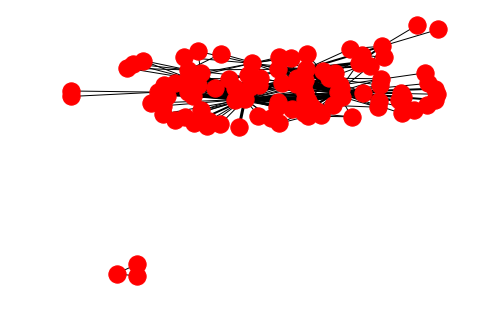

In [24]:
weights = [G_authors[u][v]['count'] for u,v in G_authors.edges]
nx.draw_spring(G_authors,width=weights)

In [ ]:
nx.draw_spring(G_papers)

In [ ]:
edges_papers.groupby(['paper1','paper2']).count().reset_index()